In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI

In [3]:
import numpy as np
from time import sleep

In [4]:
%%capture
!pip3 install robot_descriptions
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH
from robot_descriptions.skydio_x2_description import URDF_PATH

In [5]:
from mujoco_simulator.model_builder import ModelBuilder
from mujoco_simulator.simulator import MujocoRender
model_wrapper = ModelBuilder(MJCF_PATH)
model_wrapper.add_arena()
model_wrapper.build()
ren = MujocoRender(model=model_wrapper, 
                   start=True, 
                   convention='pin')
Q_INIT = np.array([0, 0, 1.0, 0, 0, 0,1])
ren.set_state(Q_INIT)

Process render is starting!


In [6]:
from darli.model import Functional
from darli.backend import CasadiBackend, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
import casadi as cs

model = Functional(CasadiBackend(URDF_PATH))
# TODO: add selector
selector = np.array([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [1.0, 1.0, 1.0, 1.0],
                     [-0.18, 0.18, 0.18, -0.18],
                     [0.14, 0.14, -0.14, -0.14],
                     [-0.0201, 0.0201, 0.0201, -0.0201]])

model.update_selector(selector)

In [7]:
di = DI(
    nq = model.nq,
    nu = 4,
    free_body = True,
    selector = selector,
    lagrangian=model.lagrangian,
)

(0, 1)


In [8]:
di.add_constraint(di.q[3:].T @ di.q[3:] - 1)

lambda


In [9]:
del_residual = di.get_residual()
del_residual

Function(del:(q-1[7],q[7],q+1[7],dt,lambda[2],u[4])->(DEL Residual[9]) SXFunction)

Define the variables in tangent space and get the configuration via exponential:

In [10]:

ns = 40

opti_problem = cs.Opti()
tf = opti_problem.parameter(1)
dt = tf / ns

state = opti_problem.variable(model.nq + model.nv, ns+1)
q = state[:model.nq, :]
v = state[model.nq:, :]
u = opti_problem.variable(model.nu, ns)
lmbdas = opti_problem.variable(1, ns)

q0 = opti_problem.parameter(model.nq)
qf = opti_problem.parameter(model.nq)

In [11]:
solver = 'var'

In [12]:

position_weight = opti_problem.parameter(1)
# orientation_weight = opti_problem.parameter(1)
acceleration_weight = opti_problem.parameter(1)
velocity_weight = opti_problem.parameter(1)
control_weight = opti_problem.parameter(1)
control_max = opti_problem.parameter(model.nu)

fd = model.forward_dynamics

cost = 0 
for i in range(1, ns):
    if solver == 'var':
        opti_problem.subject_to(del_residual(q[:, i - 1], q[:, i], q[:, i + 1], dt, lmbdas[:, i - 1], u[:, i - 1]) == 0)
    else:
        dv_i = fd(q[:,i], v[:,i], u[:, i])
        opti_problem.subject_to(v[:, i+1] == v[:,i] + dt*dv_i)
        opti_problem.subject_to(q[:,i+1] == model.backend.integrate_configuration(q[:,i], v[:,i]*dt))
    
    
    cost += position_weight*cs.sumsqr(q[:3,i] - qf[:3])*dt
    # so3_error = SO3(xyzw=q[3:,i]).distance(SO3(xyzw = qf[3:]))**2
    # cost += orientation_weight*so3_error*dt
    cost += control_weight*cs.sumsqr(u[:,i])*dt
    # cost += velocity_weight*cs.sumsqr(v[:,i])*dt
    # cost += acceleration_weight*cs.sumsqr(dv_i)*dt
    # opti_problem.subject_to(opti_problem.bounded(np.zeros(model.nu), u[:, i], control_max))
    opti_problem.subject_to(q[2, i] >= 0.4)
    
# opti_problem.subject_to(v[:,0] == np.zeros(model.nv))
# opti_problem.subject_to(v[:, -1] == np.zeros(model.nv))
opti_problem.subject_to(q[:, 0] == q0)
opti_problem.subject_to(q[:, -1] == qf)

opti_problem.minimize(cost)
opti_problem.solver('ipopt')

In [13]:
np.random.seed(42)

In [14]:
Q_INIT = np.array([0, 0, 1.5, 0,0,0, 1])
quat_random = np.random.rand(4)
quat_random /= np.linalg.norm(quat_random)
Q_INIT[3:] = quat_random
Q_FINAL = np.array([0, 0., 2.5, 0, 0, 0, 1])
Q_FINAL[:3] += np.random.randn(3)

t_final = 3


opti_problem.set_value(control_max, 50*np.ones(model.nu) )
opti_problem.set_value(q0, Q_INIT)
opti_problem.set_value(qf, Q_FINAL)
opti_problem.set_value(tf[0], t_final)

opti_problem.set_value(position_weight[0], 5)
# opti_problem.set_value(orientation_weight[0], 0)
opti_problem.set_value(velocity_weight[0], 10)
opti_problem.set_value(acceleration_weight[0], 5)
opti_problem.set_value(control_weight[0], 5)
opti_problem.set_initial(q[3:,:], np.array([Q_INIT[3:]]*(ns+1)).T)
opti_problem.set_initial(q[:3,:], np.linspace(Q_INIT[:3], Q_FINAL[:3], ns+1).T)

ren.set_state(Q_INIT)
ren.markers[ns+1](position=Q_FINAL[:3],
                color=[1, 0, 0, 0.5],
                size=0.04)
ren.markers[ns+2](position=Q_INIT[:3],
                color=[0, 1, 0, 0.5],
                size=0.04)


In [15]:
try:
    sol = opti_problem.solve()
    q_opt = opti_problem.value(q)
    v_opt = opti_problem.value(v)
    u_opt = opti_problem.value(u)
except Exception as e:
    q_opt = opti_problem.debug.value(q)
    v_opt = opti_problem.debug.value(v)
    u_opt = opti_problem.debug.value(u)
    print(e)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6137
Number of nonzeros in inequality constraint Jacobian.:       39
Number of nonzeros in Lagrangian Hessian.............:     4179

Total number of variables............................:      733
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      365
Total number of inequality c

In [16]:
ren.set_state(Q_INIT)

In [17]:
for i in range(ns+1):
    ren.set_state(q_opt[:, i])

    for j in range(i):
        ren.markers[j](position=q_opt[:3, j],
                       color=[0, 0, 1, 0.5],
                       size=j*0.02/ns + 0.01)

    ren.markers[ns+1](position=Q_FINAL[:3],
                      color=[1, 0, 0, 0.5],
                      size=0.04)
    ren.markers[ns+2](position=Q_INIT[:3],
                    color=[0, 1, 0, 0.5],
                    size=0.04)
    sleep(t_final/ns)

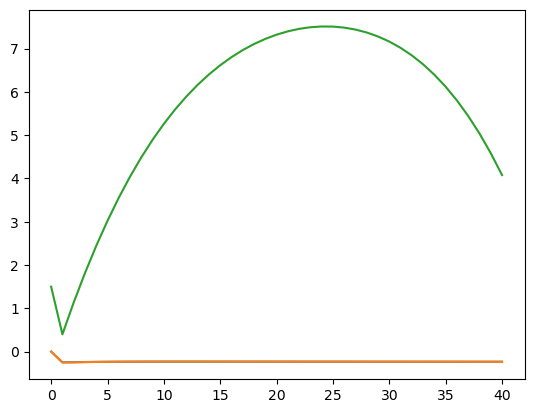

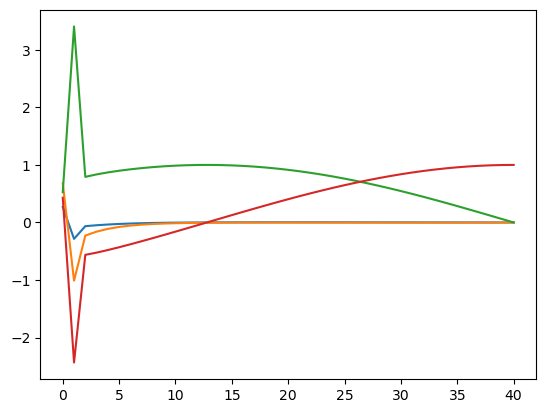

In [18]:
import matplotlib.pyplot as plt
plt.plot(q_opt[:3,:].T)
plt.show()

plt.plot(q_opt[3:7,:].T)
plt.show()


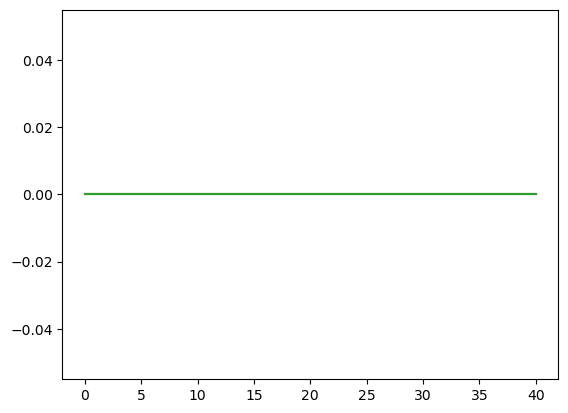

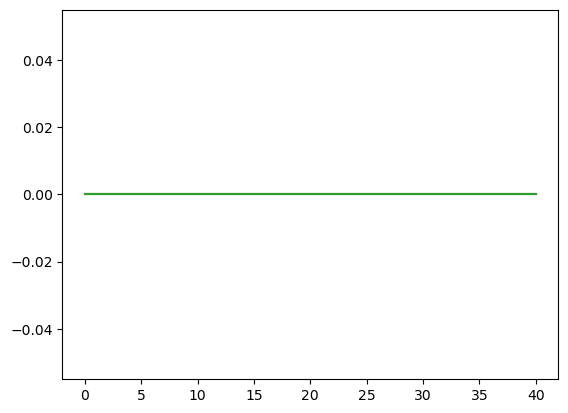

In [19]:
plt.plot(v_opt[:3,:].T)
plt.show()

plt.plot(v_opt[3:,:].T)
plt.show()


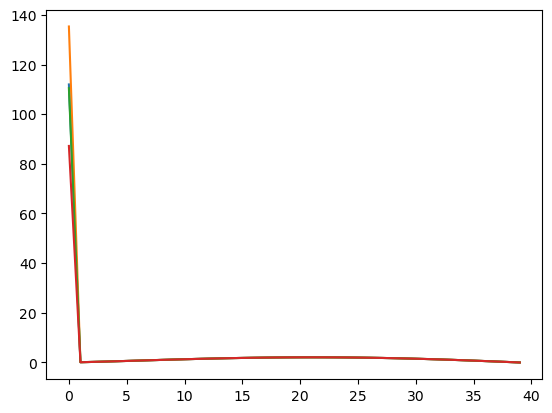

In [20]:

plt.plot(u_opt.T)
plt.show()

In [21]:
q_opt.shape

(7, 41)

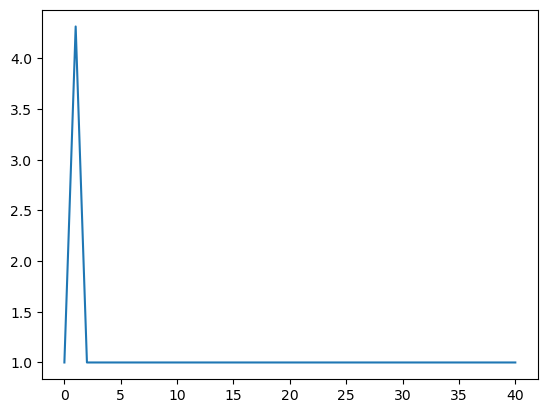

In [22]:
plt.plot(np.linalg.norm(q_opt[3:7, :].T, axis=1))
plt.show()

In [23]:
np.linalg.norm(q_opt[3:7,:].T, axis = 1)

array([1.       , 4.3150052, 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       ])